In [1]:
%matplotlib widget

In [2]:
import copy
import doctest
import enum
import itertools
import logging
import math
import multiprocessing
from collections import defaultdict
from dataclasses import dataclass
from functools import total_ordering
from typing import Callable
from typing import Collection
from typing import List
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import TypeVar

import matplotlib.pyplot as plt
import torch
import tqdm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.poisson import Poisson

In [3]:
# adjust the logger level to see debugging info
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
#logger.setLevel(logging.DEBUG)

In [4]:
# doctest to catch regressions, copy below relevant code section
# doctest.testmod()

# Dynamic Programming

## Key Concepts

## Definitions

**Dynamic Programming (DP)**: A collection of algorithms that can be used to compute optimal policies given a perfect model of the environment as a Markov decision process (MDP).

**Policy Evaluation/Prediction Problem**: Computing the state-value function $v_\pi$ for an arbitrary policy $\pi$.

**Iterative Policy Evaluation**: 

**Policy Improvement Theorem**:

**Policy Iteration**:

## Notation

## Introduction

Dynamic programming refers to a group of algorithms that can be used to compute optimal policies given a perfect model of the environment as a Markov decision process.

Their use in RL is limited as they assume the existance of a perfect model and they are also computationally expensive.

However, they are important theoretically as they provide an essential foundation for understanding the methods presented in the rest of the book. The other methods can be viewed as attempts to achieve the same effect as DP but with less computation and without assuming a perfect model of the environment. 





---

It is usually assumed that the state, action, and reward sets, $\mathcal{S}$, $\mathcal{A}$, $\mathcal{R}$, area finite and that the dynamics are given by a set of probabilities $p(s', r | s, a)$ for all $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$, $r \in \mathcal{R}$, and $s' \in \mathcal{S}^+$ ($\mathcal{S}^+$ is $\mathcal{S}$ plus a terminal state if the problem is episodic.

DP ideas can be applied to continuous state and action spaces but exact solutions are only possible in special cases. A common way of avoiding this is to quantize the state and action spaces.

---

The key idea of DP, and reinforcement learning generally, is the use of value functions to organize and structure the search for good policies. 

We can obtain optimal policies once we have found the optimal value functions $v_*$ or $q_*$ which satisfy the Bellman optimality equations:

\begin{align}
    v_*(s) &\doteq \max_a \mathbb{E}[ G_t | S_t = s, A_t = a] \\
           &= \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v_*(s')]
\end{align}

\begin{align}
    q_*(s, a) &\doteq \mathbb{E}[R_t + \gamma \max_{a'} q_*(S_{t + 1}, a') | S_t = s, A_t = a] \\
              &= \sum_{s', r} p(s', r | s, a)[r + \gamma max_{a'} q_*(s', a')]
\end{align}

Dynamic programming algorithms are obtained by turning Bellman equations such as these into assignments (update rules) for improving approximations of the desired value functions.

## 4.1: Policy Evaluation (Prediction)

Policy evaluation, or prediction, aims to compute the state-value function $v_\pi$ for an arbitrary policy $\pi$. 

Recall the definition of the state-value function:

\begin{align}
    v_\pi(s) &\doteq \mathbb{E}_\pi [G_t | S_t = s] \\
            &= \mathbb{E}_\pi [R_t + \gamma G_{t + 1} | S_t = s] \\
            &= \mathbb{E}_\pi [R_t + \gamma \mathbb{E}_\pi[G_{t + 1} | S_{t + 1} = s'] | S_t = s] \\
            &= \mathbb{E}_\pi [R_t + \gamma v_\pi(S_{t + 1}) | S_t = s, A_t = a] \\
            &= \sum_a \pi(a|s) \sum_{s', r} p(s', r | s, a)[r + \gamma v_\pi(s')]
\end{align}

The existance and uniqueness of $v_\pi$ are guaranteed as long as either $\gamma < 1$ or eventual terminal is guaranteed from all states under policy $\pi$.

If the environments dynamics - $p(s', r | s, a)$ - are completely known then this is a system of $|\mathcal{S}|$ simultaneous linear equations in $|\mathcal{S}|$ unknowns.

In principle its solution is a straightforward but tedious computation. 

For our pruposes the iterative solution methods are most suitable.

### Iterative Policy Evaluation

Consider a sequence of approximate value functions $v_0, v_1, v_2, \dots$ each mapping $\mathcal{S}^+$ to $\mathbb{R}$. 

The initial approximation $v_0$ is chosen arbitrarily (except that the terminal state, if any, must be given value 0), and each successive approximation is obtained by using the Bellman equation $v_\pi$ as an update rule:

\begin{align}
    v_{k+1}(s) &\doteq \mathbb{E}_\pi [R_{t+1} + \gamma v_k(S_{t+1}) | S_t = s] \\
               &= \sum_a \pi(a | s) \sum_{s', r}p(s', r | s, a)[r + \gamma v_k(s')]
\end{align}

$v_k = v_n$ is a fixed point for this update rule. In general, the sequence ${v_k}$ can be shown to converge to $v_\pi$ as $k \rightarrow \infty$. This algorithm is called _iterative policy evaluation_.

The update rule is an _expected_ update because it is based on an expectation over all possible next states rather than on a sample next state.

An implementation can store two arrays, one for $v_k$ and one for $v_{k + 1}$ or it can do in-place updates. The in-place algorithm has a signficant impact on the rate of convergence. 

---

Comment: To me it's amazing that this simple technique converges so quickly to an accurate estimate of the true value function for a given policy!

---

Let's begin by writing a generic iterative policy evaluation function. First we write a couple of helpers to run a function in parallel without requiring the use of pickle:

In [52]:
def consume(f, q_in, q_out):
    while True:
        i, x = q_in.get()
        if i is None:
            break
        q_out.put((i, f(x)))


def parmap(f: Callable, data: Sequence, nprocs=multiprocessing.cpu_count(), display_progress=False):
    """Execute f over X in using ``nprocs`` processes.
    
    The idea is to create ``nprocs`` processes that consume ``data``
    from a queue. Once the processes have been started and the
    queue created the values in ``data`` are pushed into the queue
    along with their index. The index will be returned with the result 
    and it allows the original order of the list to be restored. After 
    pushing the ``data``, ``nprocs`` tokens indicating that the end of
    the input has been reached are pushed. Each process terminates when 
    it pulls one of these token from the queue.
    
    The results are sent back via a second queue and sorted by the 
    index.
    """
    q_in = multiprocessing.Queue(1)
    q_out = multiprocessing.Queue()

    proc = [
        multiprocessing.Process(target=consume, args=(f, q_in, q_out))
        for _ in range(nprocs)
    ]
    
    for p in proc:
        p.daemon = True
        p.start()

    sent = [
        q_in.put((i, x)) 
        for i, x in enumerate(tqdm.tqdm(data, mininterval=0.5, desc="parmap queueing requests: "))
    ]
    [q_in.put((None, None)) for _ in range(nprocs)]

    if not display_progress:
        to_get = range(len(sent))
    else:
        to_get = tqdm.trange(len(sent), mininterval=0.5, desc="parmap getting results: ")
        
    res = [q_out.get() for _ in to_get]
    [p.join() for p in proc]

    return [x for i, x in sorted(res)]

Now we can write a generic iterative policy evaluation function: 

In [6]:
StateT = TypeVar("StateT")
ActionT = TypeVar("ActionT")
RewardT = TypeVar("RewardT", int, float)


def iterative_policy_evaluation(
    states: Sequence[StateT],
    actions: Callable[[StateT], Sequence[ActionT]],
    dynamics: Callable[[StateT, ActionT], Sequence[Tuple[StateT, RewardT, float]]],
    policy: Callable[[StateT, ActionT], float],
    theta: int = 0.1,
    gamma: float = 0.9,
    inplace: bool = True,
    parallel: bool = True,
    init_values: Optional[Sequence[RewardT]] = None
) -> Sequence[RewardT]:
    """Returns a ``Sequence`` containing the estimated returns for all states.
    
    Args:
        states: A ``Sequence`` containing all possible states.
        
        actions: A ``Callable`` that returns all possible actions
            given a state.
        
        dynamics: A ``Callable`` that returns all possible
            ``(next state, reward, log_prob)`` tuples given
            a ``state`` and an ``action``. ``log_prob`` is 
            the log probability of transitioning to 
            ``next_state`` and receiving ``reward`` when
            taking ``action`` in ``state``.
            
        policy: A ``Callable`` that returns the log probability
            of taking ``action`` when in ``state``.
        
        theta: Stop when the maximum absolute difference between the 
            newly computed and previous expected return in one 
            iteration is less than this value.
        
        gamma: Discount factor.
        
        inplace: Perform expected updates in place.
        
        parallel: For a given state, compute the dynamics for 
            all available actions in paralle.
            
        init_values: If None the initial value estimates are set to 0.
            If not None, these values are used as the initial value 
            estimates (length must be equal to ``len(states)``).
    """
    if theta <= 0.0:
        raise ValueError(f"theta={theta} must be > 0.0")
        
    # initialize all estimated values
    zero_vals = lambda: [0.0] * len(states)
    if init_values is not None:
        if len(states) != len(init_values):
            raise ValueError(
                f"len(states)={len(states)} must be equal to "
                f"len(init_values)={len(init_values)}"
            )
        values = init_values
    else:
        values = zero_vals()
        
    if not inplace:
        values_prime = zero_vals()
    
    # create maps for state->index, index->state
    idx_state = dict(enumerate(states))
    state_idx = dict([(s, idx) for idx, s in enumerate(states)])

    iteration = 0
    while True:
        # iterate until delta < theta
        delta = 0.0
        
        pbar = tqdm.tqdm(states)
        for i, state in enumerate(pbar):
            # for each state perform an expected update
            
            # get all available actions we can take in this state
            avail_actions = actions(state)
            
            # for each available action, compute 
            # (next state, action, reward) tuples
            if parallel:
                nsrs = parmap(
                    lambda action: dynamics(state, action), 
                    avail_actions
                )
            else:
                nsrs = [
                    dynamics(state, action) 
                    for action in avail_actions
                ]

            # update expected return over all
            # (next state, action, reward) tuples
            v_prime = 0
            for action, nsr in zip(avail_actions, nsrs):
                for next_state, reward, log_prob in nsr:
                    v_prime += (
                        math.exp(policy(state, action) + log_prob) *
                        (reward + gamma * values[state_idx[next_state]])
                    )
                    
            # update delta 
            delta = max(delta, abs(values[i] - v_prime))
            pbar.set_description(f"iter: {iteration:4d}, max(delta): {delta:7.3f}")
            
            # modify expected return values, possibly inplace
            if inplace:
                values[i] = v_prime
            else:
                values_prime[i] = v_prime

        if not inplace:
            values = values_prime
            values_prime = zero_vals()

        if delta < theta:
            break
            
        iteration += 1
            
    return values

This is used for all of the examples in this notebook, starting with Gridworld:

In [7]:
# Example 4.1: Gridworld
# 
# 0 is the single terminal state
#
# R_t = -1 on all transitions except if in terminal state, then 0
#
# Can transition up, down, left, right. Board does not loop around,
# attempting to move out of the board results in staying in the same
# state. e.g. moving up in state 1 results in staying in state 1.
#
# |  0 |  1 |  2 |  3 | 
# |  4 |  5 |  6 |  7 |
# |  8 |  9 | 10 | 11 |
# | 12 | 13 | 14 |  0 |

TERMINAL = 0
states = list(range(15))


class GWAction(enum.Enum):
    UP    = enum.auto()
    DOWN  = enum.auto()
    RIGHT = enum.auto()
    LEFT  = enum.auto()
    
    
def actions(state: int) -> Sequence[GWAction]:
    if state == TERMINAL:
        return []
    return list(GWAction)


def grid_world(state: int, action: GWAction) -> Tuple[int, int]:
    """Returns a tuple containing the state and reward.
    
    Example:
    
        >>> grid_world(1, GWAction.DOWN)
        (5, -1)
        
        Unable to move out of terminal state and receive no reward:
        
        >>> [grid_world(0, a) for a in GWAction]
        [(0, 0), (0, 0), (0, 0), (0, 0)]
        
        >>> grid_world(11, GWAction.DOWN)
        (0, -1)
        
    """
    if state == TERMINAL:
        return state, 0
    
    if action == GWAction.LEFT:
        if state % 4 == 0:
            #  unable to move further left
            return state, -1
        return state - 1, -1
    
    if action == GWAction.RIGHT:
        if state == 14:
            # move to terminal state
            return 0, -1
        
        if (state + 1) % 4 == 0:
            # unable to move further right
            return state, -1
        
        return state + 1, -1
    
    if action == GWAction.UP:
        if state < 4:
            return state, -1
        return state - 4, -1
    
    if action == GWAction.DOWN:
        if state > 11:
            return state, -1
        return (state + 4) % 15, -1
    
    
def dynamics(state: int, action: GWAction) -> Sequence[Tuple[StateT, RewardT, float]]:
    next_state, reward = grid_world(state, action)
    return [(next_state, reward, 0.0)]

In [8]:
def uniform_random_policy(state: int, action: GWAction) -> float:
    return math.log(0.25)

In [9]:
iterative_policy_evaluation(
    states=states,
    actions=actions,
    dynamics=dynamics,
    policy=uniform_random_policy,
    theta=0.1,
    gamma=1.0,
    parallel=False
)

iter:   35, max(delta):   0.092: 100%|██████████| 15/15 [00:00<00:00, 2935.54it/s]


[0,
 -13.365544179821896,
 -19.08788486488386,
 -20.996048208664405,
 -13.365544179821896,
 -17.221439462525268,
 -19.154662163678374,
 -19.164328090982405,
 -19.087884864883854,
 -19.154662163678367,
 -17.28668964521687,
 -13.467433715738661,
 -20.9960482086644,
 -19.1643280909824,
 -13.46743371573866]

### Policy Improvement Theorem

The reason to compute the value function for a policy is to use it find better policies!

We now know how good it is to follow policy $\pi$ from state $s$, $v_\pi(s)$.

We can now compare this against choosing a possibly different action $a$ in state $s$ and thereafter following $\pi$ as usual. This quantity is:

\begin{align}
    q_\pi(s, a) &\doteq \mathbb{E}[G_t | S_t = s, A_t = a] \\
                &= \sum_{s', r} p(s', r | s, a)[r + v_\pi(s')]
\end{align}

If this value is greater than $v_\pi(s)$ then it is better to select $a$ once in $s$ and then follow $\pi$ than it is to follow $\pi$ all the time. 

This leads to the policy improvement theorem:

---

**Policy improvement theorem**:

Let $\pi$ and $\pi'$ be any pair of deterministic policies such that for all $s \in \mathcal{S}$,

\begin{equation}
    q_\pi(s, \pi'(s)) \geq v_\pi(s)
\end{equation}

Then policy $\pi'$ must obtain greater or equal expected return from all states $s \in mathcal{S}$:

\begin{equation}
    v_{\pi'}(s) \geq v_\pi(s)
\end{equation}

If there is a strict inequality in the first equation, then there is a strict inequality in the second for that state.

---

Proof of the policy improvement theorem. Idea: start from $v_\pi(s) \leq q_\pi(s, \pi'(s))$ and keep expanding the right hand side:

\begin{align}
v_\pi(s) &\leq q_\pi(s, \pi'(s)) \\
         &= \mathbb{E}[R_{t+1} + \gamma v_\pi(S_{t + 1}) | S_t = s, A_t = \pi'(s)] \\
         &\leq \mathbb{E}_{\pi'}[R_{t+1} + \gamma q_\pi(S_{t+1}, \pi'(S_{t+1})) | S_t = s] \\
         &= \mathbb{E}_{\pi'}[R_{t+1} + \gamma \mathbb{E}[R_{t+2} + \gamma v_\pi(S_{t+2}) | S_{t+1}, A_{t+1} = \pi'(S_{t+1})] | S_t = s] \\
         &= \mathbb{E}_{\pi'}[R_{t+1} + \gamma R_{t+2} + \gamma^2 v_\pi(S_{t+2}) | S_t = s] \\
         &\leq \mathbb{E}_{\pi'}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 v_\pi(S_{t+3}) | S_t = s] \\
         &\dots \\
         &\leq \mathbb{E}_{\pi'}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots | S_t = s] \\
         &= v_{\pi'}(s)
\end{align}

---

We have seen how to evaluate a policy at a single state with a particular action. What about changing all possible actions to those that appear best according to $q_\pi(s, a)$? 

This is the _greedy policy_ $\pi'$:

\begin{align}
    \pi'(s) &\doteq \text{argmax}_a q_\pi(s, a) \\
            &= \text{argmax}_a \mathbb{E}[R_{t+1} + \gamma v_\pi(S_{t+1}) | S_t = s, A_t = a] \\
            &= \text{argmax}_a \sum_{s', r} p(s', r | s, a) [ r + \gamma v_\pi(s')]
\end{align}

The greedy policy takes the action that looks best in the short term according to $v_\pi$. It meets the conditions of the policy improvement theorem so it must be as good or better than the original policy.

**Policy Improvement**: The process of making a new policy that improves on an original policy by making it greedy with respect to the value function of the original policy.

If the new greedy policy $\pi'$ is as good as but not better than the old policy then $v_\pi = v_{\pi'}$ meaning we have reached the optimal policy:

\begin{align}
    v_{\pi'}(s) &= \max_a \mathbb{E}[R_{t + 1} + \gamma v_{\pi'}(S_{t+1}) | S_t = s, A_t = a] \\
                &= \max_a \sum_{s', r} p(s', r | s, a) \left[r + \gamma v_{\pi'}(s') \right] \\
                &= v_*(s)
\end{align}

---

Quick summary: Given some policy $\pi$ we can compute an accurate estimate of the state-value function using the iterative policy evaluation algorithm. Given the state-value function, we can improve upon the policy by picking the greedy action in each state. That is, form a new policy $\pi'$ where the action in a given state is chosen to maximize $q_\pi(s, a)$. We have proven that this policy must have value greater than or equal to the original policy $\pi$. If it is greater than then we have a better policy. If it is equal to, then the policy is an optimal policy $\pi_*$.

Forming the new policy requires doing a one-step look-ahead at all states. i.e. iterating through all possible actions and computing $q_\pi(s, a)$. 

---

<p style="color:red">TODO: Prove policy improvement for the case when the policy is stochastic</p>

### Policy Iteration

The above process of computing the state-value function for a given policy $\pi$ and then doing policy improvement to yield a new policy $\pi'$ can be iterated leading to a sequence of monotonically improving policies and value functions:

\begin{equation}
    \pi_0      \overset{\text{E}}{\rightarrow} 
    v_{\pi_0}  \overset{\text{I}}{\rightarrow}
    \pi_1      \overset{\text{E}}{\rightarrow} 
    v_{\pi_1}  \overset{\text{I}}{\rightarrow}
    \pi_2      \overset{\text{E}}{\rightarrow} 
    \dots      \overset{\text{I}}{\rightarrow}
    \pi_*      \overset{\text{E}}{\rightarrow} 
    v_{\pi_*}
\end{equation}

A finite MDP only has a finite number of policies so this process must converge to the optimal policy in a finite number of steps.

---

In [9]:
max_cars = 20
max_move = 5

rent_cost = 10

In [10]:
# Example 4.2: Jack's Car Rental

states = [
    (n_0, n_1) 
    for n_0 in range(max_cars + 1) 
    for n_1 in range(max_cars + 1)
]


@dataclass
class Action:
    """+ve moves from loc 0 to 1, -ve moves from loc 1 to 0"""
    n_move: int
        
    def __hash__(self):
        return hash(self.n_move)
    

def gen_actions(max_move):
    """Returns a function that returns all actions for a given state.
    
    Example:
        >>> max_move = 10
        >>> for a in gen_actions(max_move)((3, 15)):
        ...     print(a)
        Action(n_move=-10)
        Action(n_move=-9)
        Action(n_move=-8)
        Action(n_move=-7)
        Action(n_move=-6)
        Action(n_move=-5)
        Action(n_move=-4)
        Action(n_move=-3)
        Action(n_move=-2)
        Action(n_move=-1)
        Action(n_move=0)
        Action(n_move=1)
        Action(n_move=2)
        Action(n_move=3)
         
        >>> gen_actions(10)((0, 0))
        [Action(n_move=0)]
         
    """
    def actions(state):
        acts = []
        assert len(state) == 2   # assume only 2 states
        for n_move in range(-max_move, max_move + 1):
            if n_move > 0 and state[0] < n_move:
                continue
            if n_move < 0 and state[1] < abs(n_move):
                continue
            acts.append(Action(n_move))
        return acts
    return actions


def gen_dynamics(
    ret_means: List[int],
    req_means: List[int],
    max_cars: int, 
    action_reward_fn: Callable[[Action], float], 
    rent_cost: int,
    next_state_reward_fn: Optional[Callable[[List[int]], float]] = None,
    eps: float = 1e-5
):
        
    ret_dists = [
        torch.distributions.Poisson(mean) 
        for mean in ret_means
    ]
    req_dists = [
        torch.distributions.Poisson(mean)
        for mean in req_means
    ] 
    
    ret_dist_lps = []
    for ret_dist in ret_dists:
        tmp = []
        for i in range(0, max_cars + 1):
            tmp.append(ret_dist.log_prob(i).item())
        ret_dist_lps.append(tmp)

    req_dist_lps = []
    for req_dist in req_dists:
        tmp = []
        for i in range(0, max_cars + 1):
            tmp.append(req_dist.log_prob(i).item())
        req_dist_lps.append(tmp)
        
    def dynamics(
        state: List[int],
        action: Action
    ) -> List[Tuple[List[int], int, float]]:         
        # execute possible action
        s = [state[0], state[1]]
        
        log_probs = {}
        counts = {}
    
        n_move = 0
        if action.n_move > 0:
            n_move = min(action.n_move, s[0])
        else:
            n_move = -min(-action.n_move, s[1])
            
        s[0] = min(max_cars, s[0] - n_move)
        s[1] = min(max_cars, s[1] + n_move)
        reward = action_reward_fn(action)

        # iterate over all combinations of cars returned
        ret_0 = 0
        ret_0_max = False
        while not ret_0_max:
            if s[0] + ret_0 == max_cars:
                ret_0_lp = 1.0
                if ret_0 > 0:
                    ret_0_lp -= sum([math.exp(ret_dist_lps[0][k]) for k in range(ret_0)])
                ret_0_lp = -float("inf") if abs(ret_0_lp) <= eps else math.log(ret_0_lp)
                ret_0_max = True
            else:
                ret_0_lp = ret_dist_lps[0][ret_0]

            ret_1 = 0
            ret_1_max = False
            while not ret_1_max:
                if s[1] + ret_1 == max_cars:
                    ret_1_lp = 1.0
                    if ret_1 > 0:
                        ret_1_lp -= sum([math.exp(ret_dist_lps[1][k]) for k in range(ret_1)])
                    ret_1_lp = -float("inf") if abs(ret_1_lp) <= eps else math.log(ret_1_lp)
                    ret_1_max = True
                else:
                    ret_1_lp = ret_dist_lps[1][ret_1]

                # subtract cars rented
                req_0 = 0
                req_0_max = False
                while not req_0_max:
                    if s[0] + ret_0 == req_0:
                        req_0_lp = 1.0
                        if req_0 > 0:
                            req_0_lp -= sum([math.exp(req_dist_lps[0][k]) for k in range(req_0)])
                        req_0_lp = -float("inf") if abs(req_0_lp) <= eps else math.log(req_0_lp)
                        req_0_max = True
                    else:
                        req_0_lp = req_dist_lps[0][req_0]

                    req_1 = 0
                    req_1_max = False
                    while not req_1_max:
                        #for req_0 in range(max_cars + 1):#s[0] + ret_0 + 1):
                        if s[1] + ret_1 == req_1:
                            req_1_lp = 1.0
                            if req_1 > 0:
                                req_1_lp -= sum([math.exp(req_dist_lps[1][k]) for k in range(req_1)])
                            req_1_lp = -float("inf") if abs(req_1_lp) <= eps else math.log(req_1_lp)
                            req_1_max = True
                        else:
                            req_1_lp = req_dist_lps[1][req_1]

                        log_prob = ret_0_lp + ret_1_lp + req_0_lp + req_1_lp

                        # compute reward and next state
                        reward_req = reward + rent_cost * (req_0 + req_1)
                        
                        next_s = (s[0] + ret_0 - req_0, s[1] + ret_1 - req_1)
                        if next_state_reward_fn is not None:
                            reward_req += next_state_reward_fn(next_s)
                        
                        t = (next_s, reward_req)
                        if t in log_probs and log_prob != -float("inf"):
                            log_probs[t] = math.log(math.exp(log_probs[t]) + math.exp(log_prob))
                        else:
                            log_probs[t] = log_prob

                        req_1 += 1

                    req_0 += 1

                ret_1 += 1

            ret_0 += 1
        
        # normalize probabilities to sum to 1
        tot = math.log(sum([math.exp(lp) for lp in log_probs.values()]))
        nexts = [(s, r, lp - tot) for (s, r), lp in log_probs.items()]
        
        return nexts
        
    return dynamics

In [11]:
def never_move_policy(state: List[int], action: Action) -> float:
    if action.n_move != 0:
        return -float("inf")
    return 0.0


def gen_const_action_fn(move_cost: float) -> Callable[[Action], float]:
    def const_action_fn(action: Action) -> float:
        return abs(action.n_move) * move_cost
    return const_action_fn

In [13]:
values = iterative_policy_evaluation(
    states=states,
    actions=gen_actions(max_move),
    dynamics=gen_dynamics(
        ret_means=[3, 2],
        req_means=[3, 4],
        max_cars=max_cars, 
        action_reward_fn=gen_const_action_fn(-2), 
        rent_cost=rent_cost
    ),
    policy=never_move_policy,
    gamma=0.9,
    theta=2000,
    parallel=True,
    init_values=None,
)

iter:    0, max(delta): 215.518: 100%|██████████| 441/441 [01:48<00:00,  4.07it/s]


In [14]:
v = torch.tensor(values).view(max_cars + 1, max_cars + 1)
for i in range(max_cars):
    print("|", end="")
    for j in range(max_cars):
        print(f"{v[i][j].item():7.2f}", end=" |")
    print()

|  37.83 |  59.63 |  67.16 |  73.75 |  79.24 |  83.61 |  86.99 |  89.58 |  91.55 |  93.06 |  94.21 |  95.09 |  95.77 |  96.29 |  96.70 |  97.10 |  97.76 |  99.40 | 102.92 | 107.86 |
|  57.69 |  72.68 |  80.71 |  87.71 |  93.52 |  98.17 | 101.79 | 104.58 | 106.72 | 108.36 | 109.63 | 110.60 | 111.35 | 111.94 | 112.42 | 112.85 | 113.37 | 114.22 | 115.66 | 117.42 |
|  62.92 |  78.38 |  86.29 |  93.17 |  98.88 | 103.46 | 107.04 | 109.82 | 111.97 | 113.63 | 114.92 | 115.91 | 116.68 | 117.28 | 117.76 | 118.20 | 118.71 | 119.55 | 121.00 | 122.80 |
|  67.11 |  82.95 |  90.77 |  97.56 | 103.20 | 107.72 | 111.28 | 114.05 | 116.20 | 117.87 | 119.16 | 120.17 | 120.96 | 121.57 | 122.06 | 122.50 | 123.00 | 123.84 | 125.30 | 127.13 |
|  70.25 |  86.39 |  94.17 | 100.91 | 106.50 | 110.99 | 114.52 | 117.28 | 119.43 | 121.10 | 122.41 | 123.42 | 124.22 | 124.84 | 125.34 | 125.77 | 126.28 | 127.12 | 128.59 | 130.44 |
|  72.50 |  88.88 |  96.64 | 103.36 | 108.93 | 113.40 | 116.93 | 119.68 | 121.82 | 123.49 

In [12]:
def plot_policy(state_values, max_cars, min_val=None, max_val=None):
    X, Y = torch.meshgrid(torch.arange(max_cars + 1), torch.arange(max_cars + 1))

    xs = X.numpy().flatten()
    ys = Y.numpy().flatten()
    zs = state_values

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_trisurf(xs, ys, zs, cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5)

    ax.set_title("$v_\pi(s)$ for \"Never Move\" Policy")
    ax.set_xticks(range(0, max_cars + 1, 4))
    ax.set_xlabel("# Cars at Location 1")
    ax.set_yticks(range(0, max_cars + 1, 4))
    ax.set_ylabel("# Cars at Location 2")
    ax.set_zlabel("$v_\pi(s)$")
    
    lower, upper = ax.get_zlim()
    if min_val is not None:
        lower = min_val
    if max_val is not None:
        upper = max_val
    ax.set_zlim(lower, upper)

    plt.show()

In [16]:
plot_policy(values, max_cars)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now to implement policy improvement and improve upon the never move policy:

TODO: Math for stochastic policy case.

In [13]:
class CallablePolicyMap(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, *args):
        return self.__getitem__(args)


def policy_improvement(
    states: Sequence[StateT],
    actions: Callable[[StateT], Sequence[ActionT]],
    dynamics: Callable[[StateT, ActionT], Sequence[Tuple[StateT, RewardT, float]]],
    policy: Callable[[StateT, ActionT], float],
    values: Sequence[RewardT],
    gamma: float
) -> Tuple[Callable[[StateT, ActionT], float], bool]:
    """Returns the policy that is greedy with respect to the state value function ``values``.
    
    The return value is a tuple of the greedy policy and a bool that
    is True if the returned policy is strictly better than ``policy``.
    
    """
    policy_stable = True
    
    new_policy = CallablePolicyMap()
    state_idx_map = dict([(s, i) for i, s in enumerate(states)])
    
    for state in tqdm.tqdm(states):
        state_actions = actions(state)
        
        action_values = []
        
        for action in state_actions:
            action_value = 0.0
            for next_state, reward, log_prob in dynamics(state, action):
                action_value += math.exp(log_prob) * (reward + gamma*values[state_idx_map[next_state]])
            action_values.append((action, action_value))
            
            new_policy[(state, action)] = -float("inf")
            
        best_action, best_value = max(action_values, key=lambda a_av: a_av[1])
        
        if policy(state, best_action) != 0.0 and values[state_idx_map[state]] < best_value:
            # check value to prevent policy flipping between two
            # states with equal expected returns
            policy_stable = False
            
        new_policy[(state, best_action)] = 0.0
            
    return new_policy, policy_stable

In [14]:
def greedy_policy_plot(
    states: Sequence[StateT],
    actions: Callable[[StateT], Sequence[ActionT]],
    policy: Callable[[StateT, ActionT], float],
    add_vals: bool = False
) -> None:   
    plt.ioff()
    plt.close("all")
    fig, ax = plt.subplots()
    
    img = torch.zeros((max_cars + 1, max_cars + 1))
    n_moves = []
    for state in states:
        max_act = None
        max_prob = 0.0
        for action in actions(state):
            prob = math.exp(policy(state, action))
            if max_act is None or prob > max_prob:
                max_act = action
                max_prob = prob
        img[state[0], state[1]] = max_act.n_move
        n_moves.append((state, max_act.n_move, max_prob))

    cmap = cm.get_cmap('PiYG', 2*max_move+1)
    pos = ax.imshow(img, origin="lower", cmap=cmap, vmin=-max_move-0.5, vmax=max_move+0.5)
    
    if add_vals:
        for state, n_move, log_prob in n_moves:
            ax.text(state[1], state[0], n_move, ha="center", va="center", color="k")
    
    ax.set_ylabel("#Cars at first location")
    ax.set_xlabel("#Cars at second location")
    plt.colorbar(pos, ticks=torch.arange(-max_move, max_move + 1), ax=ax)
    plt.show()

In [15]:
%matplotlib inline

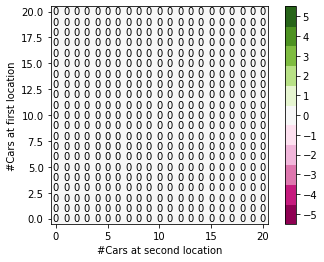

In [16]:
greedy_policy_plot(states, gen_actions(max_move), never_move_policy, add_vals=True)

In [17]:
def policy_iteration(
    states: Sequence[StateT],
    actions: Callable[[StateT], Sequence[ActionT]],
    dynamics: Callable[[StateT, ActionT], Sequence[Tuple[StateT, RewardT, float]]],
    policy: Callable[[StateT, ActionT], float],
    theta: int = 0.1,
    gamma: float = 0.9,
    inplace: bool = True,
    parallel: bool = True,
) -> None:
    optimal = False
    values = None
    
    greedy_policy_plot(states, actions, policy)
    
    while not optimal:
        values = iterative_policy_evaluation(
            states=states,
            actions=actions,
            dynamics=dynamics,
            policy=policy,
            gamma=gamma,
            theta=theta,
            inplace=inplace,
            parallel=parallel,
            init_values=values,
        )
        plot_policy(values, max_cars, min_val=0, max_val=650)
        policy, optimal = policy_improvement(
            states=states,
            actions=actions,
            dynamics=dynamics,
            policy=policy,
            values=values,
            gamma=gamma
        )
        greedy_policy_plot(states, actions, policy)
        
    return values, policy

In [ ]:
values, policy = policy_iteration(
    states=states,
    actions=gen_actions(max_move),
    dynamics=gen_dynamics(
        ret_means=[3, 2],
        req_means=[3, 4],
        max_cars=max_cars, 
        action_reward_fn=gen_const_action_fn(-2), 
        rent_cost=rent_cost
    ),
    policy=never_move_policy,
    theta=1,
    gamma=0.9,
    inplace=True,
    parallel=True
)

Exercise 4.7 changes the above setup slightly. Now the first car moved from the first to second locations is free. All other moves still cost \\$2. At each location if more than 10 cars are stored overnight a charge of \\$4 is incurred. 

In [18]:
def gen_one_free_action_fn(move_cost: float) -> Callable[[Action], float]:
    """
    
    >>> gof = gen_one_free_action_fn(-2)
    >>> gof(Action(0))
    0
    >>> gof(Action(1))
    0
    >>> gof(Action(-1))
    -2
    >>> gof(Action(2))
    -2
    >>> gof(Action(-2))
    -4
    
    """
    def one_free_action_fn(action: Action) -> float:
        n_move = abs(action.n_move)
        if action.n_move >= 1:
            n_move -= 1
        return n_move * move_cost
    return one_free_action_fn


def gen_next_state_reward_fn(penalty: float) -> Callable[[List[int]], float]:
    """
    
    >>> gns = gen_next_state_reward_fn(-4)
    >>> gns([10])
    0
    >>> gns([11])
    -4
    >>> gns([0, 11, 12, 1])
    -8
    
    """
    def next_state_reward_fn(state: List[int]) -> float:
        return penalty * sum([s > 10 for s in state])
    return next_state_reward_fn

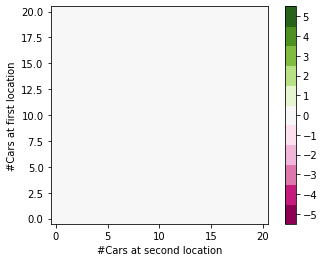

iter:    4, max(delta):  43.952: 100%|██████████| 441/441 [01:37<00:00,  4.51it/s]


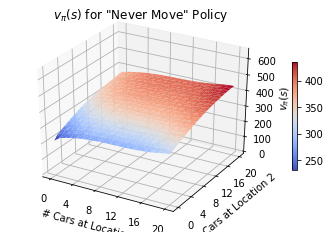

100%|██████████| 441/441 [02:40<00:00,  2.76it/s]


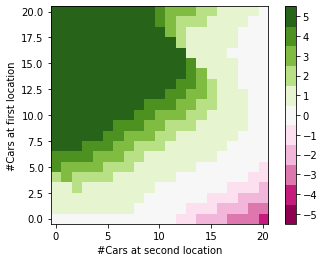

iter:    1, max(delta):  36.212: 100%|██████████| 441/441 [01:47<00:00,  4.09it/s]


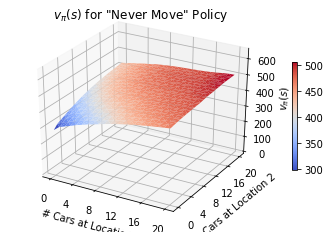

100%|██████████| 441/441 [02:46<00:00,  2.65it/s]


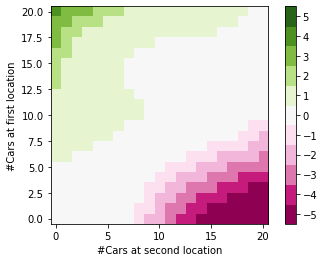

iter:    0, max(delta):  29.978: 100%|██████████| 441/441 [01:46<00:00,  4.13it/s]


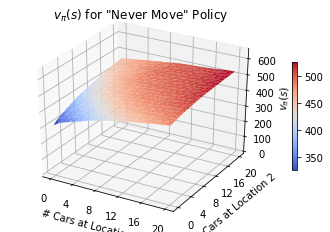

100%|██████████| 441/441 [02:41<00:00,  2.73it/s]


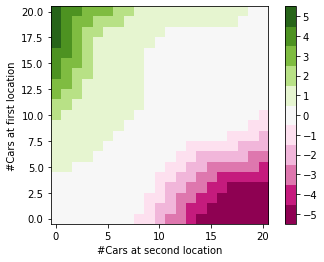

iter:    0, max(delta):  24.836: 100%|██████████| 441/441 [01:46<00:00,  4.13it/s]


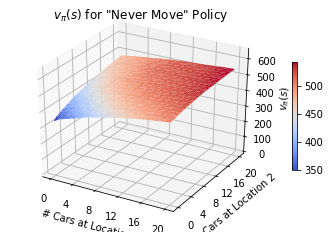

100%|██████████| 441/441 [02:43<00:00,  2.70it/s]


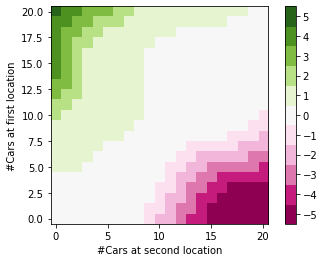

iter:    0, max(delta):  20.770: 100%|██████████| 441/441 [01:46<00:00,  4.14it/s]


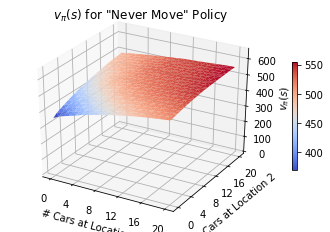

100%|██████████| 441/441 [02:41<00:00,  2.73it/s]


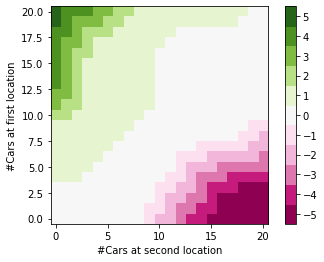

iter:    0, max(delta):  17.531: 100%|██████████| 441/441 [01:45<00:00,  4.19it/s]


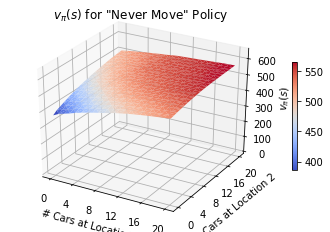

100%|██████████| 441/441 [02:38<00:00,  2.79it/s]


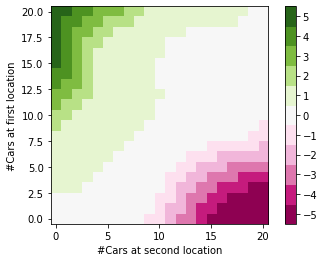

iter:    0, max(delta):  15.448: 100%|██████████| 441/441 [01:45<00:00,  4.17it/s]


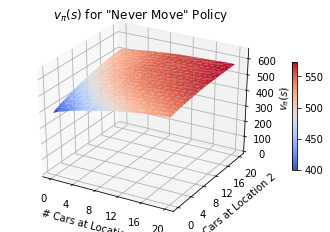

100%|██████████| 441/441 [02:41<00:00,  2.73it/s]


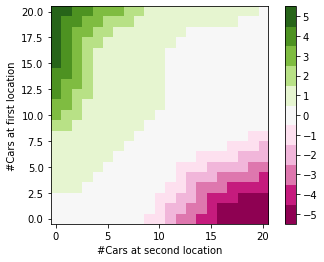

iter:    0, max(delta):  12.881: 100%|██████████| 441/441 [01:46<00:00,  4.15it/s]


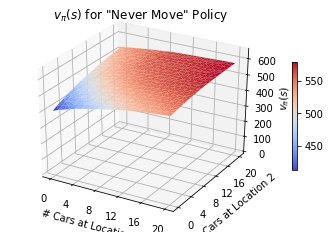

100%|██████████| 441/441 [02:43<00:00,  2.70it/s]


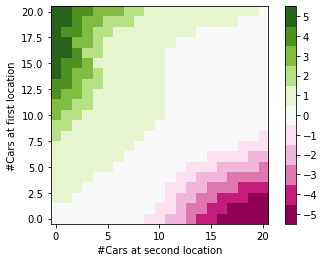

iter:    0, max(delta):  11.521: 100%|██████████| 441/441 [01:45<00:00,  4.16it/s]


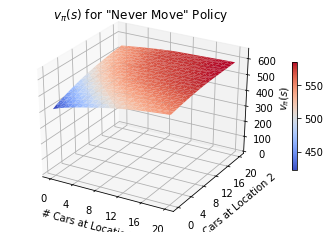

100%|██████████| 441/441 [02:43<00:00,  2.70it/s]


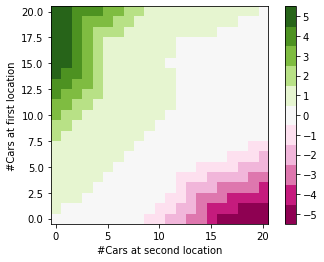

iter:    0, max(delta):  10.181: 100%|██████████| 441/441 [01:45<00:00,  4.19it/s]


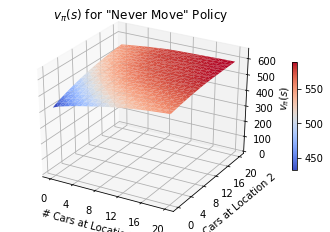

100%|██████████| 441/441 [02:40<00:00,  2.75it/s]


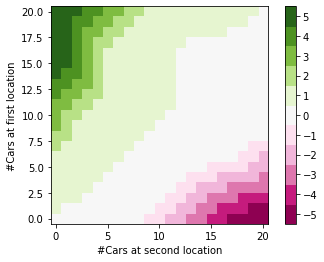

iter:    0, max(delta):   8.275: 100%|██████████| 441/441 [01:46<00:00,  4.13it/s]


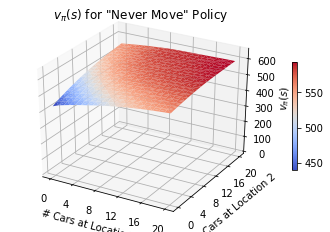

100%|██████████| 441/441 [02:36<00:00,  2.81it/s]


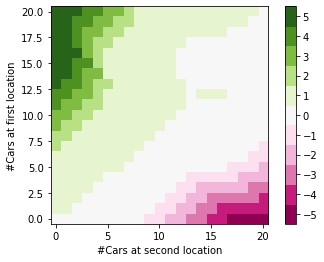

iter:    0, max(delta):   6.981: 100%|██████████| 441/441 [01:46<00:00,  4.13it/s]


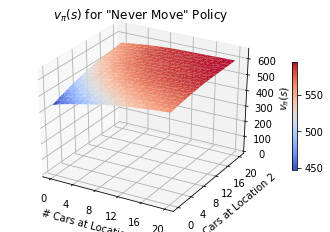

100%|██████████| 441/441 [02:41<00:00,  2.73it/s]


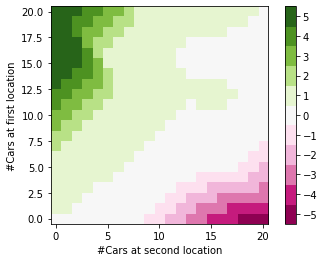

iter:    0, max(delta):   5.873: 100%|██████████| 441/441 [01:47<00:00,  4.12it/s]


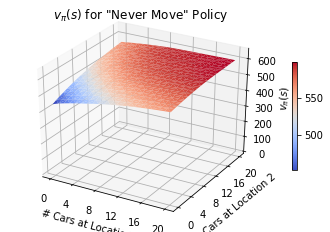

100%|██████████| 441/441 [02:40<00:00,  2.74it/s]


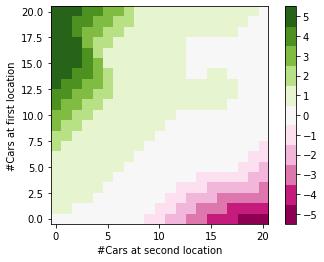

iter:    0, max(delta):   4.929: 100%|██████████| 441/441 [01:47<00:00,  4.11it/s]


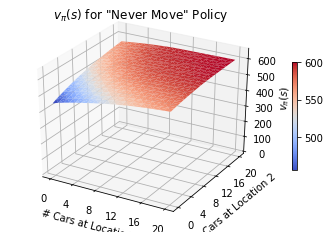

100%|██████████| 441/441 [02:43<00:00,  2.70it/s]


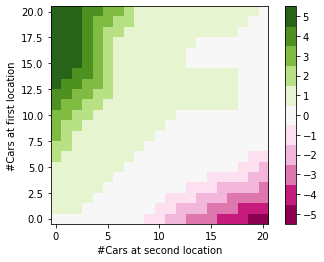

iter:    0, max(delta):   4.133: 100%|██████████| 441/441 [01:42<00:00,  4.30it/s]


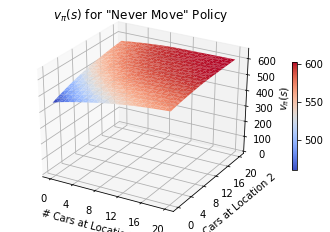

100%|██████████| 441/441 [02:33<00:00,  2.88it/s]


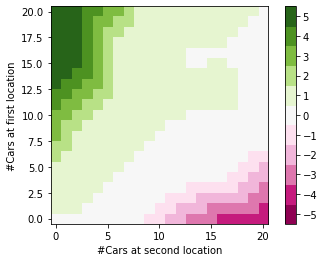

iter:    0, max(delta):   3.473: 100%|██████████| 441/441 [01:44<00:00,  4.21it/s]


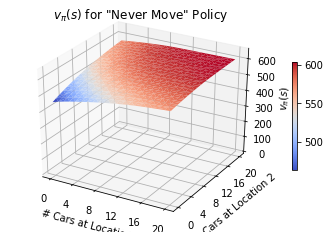

100%|██████████| 441/441 [02:40<00:00,  2.74it/s]


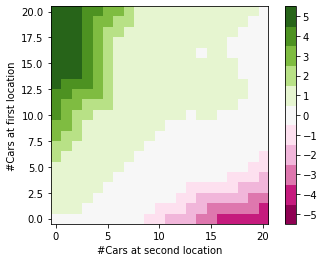

iter:    0, max(delta):   2.917: 100%|██████████| 441/441 [01:46<00:00,  4.16it/s]


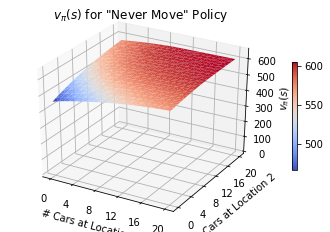

100%|██████████| 441/441 [02:37<00:00,  2.80it/s]


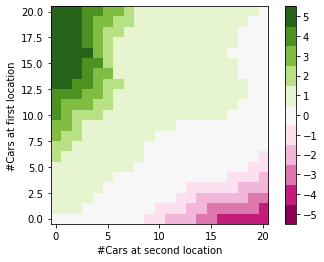

iter:    0, max(delta):   2.447: 100%|██████████| 441/441 [01:45<00:00,  4.18it/s]


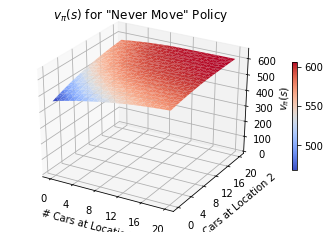

100%|██████████| 441/441 [02:41<00:00,  2.73it/s]


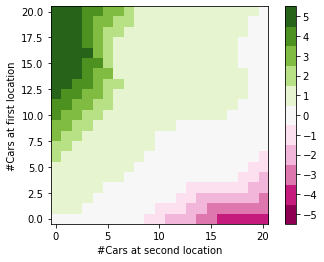

iter:    0, max(delta):   2.050: 100%|██████████| 441/441 [01:45<00:00,  4.18it/s]


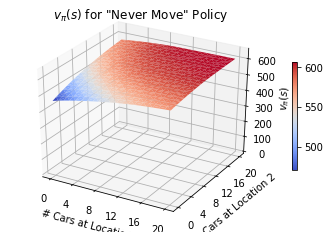

100%|██████████| 441/441 [02:35<00:00,  2.84it/s]


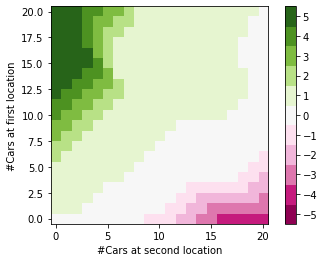

iter:    0, max(delta):   1.716: 100%|██████████| 441/441 [01:46<00:00,  4.15it/s]


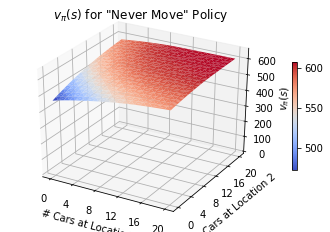

100%|██████████| 441/441 [02:37<00:00,  2.80it/s]


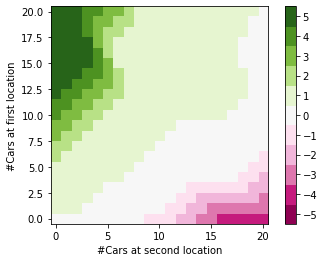

iter:    0, max(delta):   1.437: 100%|██████████| 441/441 [01:46<00:00,  4.15it/s]


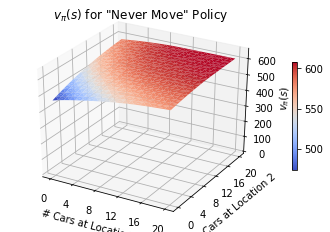

100%|██████████| 441/441 [02:40<00:00,  2.75it/s]


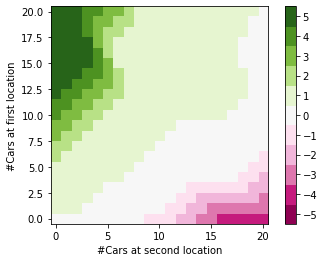

In [27]:
values, policy = policy_iteration(
    states=states,
    actions=gen_actions(max_move),
    dynamics=gen_dynamics(
        ret_means=[3, 2],
        req_means=[3, 4],
        max_cars=max_cars, 
        action_reward_fn=gen_one_free_action_fn(-2),
        next_state_reward_fn=gen_next_state_reward_fn(-4),
        rent_cost=rent_cost
    ),
    policy=never_move_policy,
    theta=50,
    gamma=0.9,
    inplace=True,
    parallel=True
)

### Action-Value Policy Iteration

Policy iteration can also be done using the action-value function, where:

\begin{align}
q_\pi(s, a) &= \mathbb{E}_\pi[G_t | S_t = s, A_t = a] \\
            &= \mathbb{E}_\pi[R_t + \gamma G_{t + 1} | S_t = s, A_t = a] \\
            &= \mathbb{E}_\pi[R_t + \gamma \mathbb{E}_\pi[G_{t + 1} | S_{t + 1} = s', A_{t + 1} = a'] | S_t = s, A_t = a] \\
            &= \mathbb{E}_\pi[R_t + \gamma q_\pi(S'_{t+1}, A'_{t + 1})  | S_t = s, A_t = a] \\
            &= \sum_{s', r} p(s', r | s, a) \left[r + \gamma \sum_{a' \in \mathcal{A}(s')} \pi(a' | s') q_\pi(s', a') \right]
\end{align}

and:

\begin{align}
q_*(s, a) &\doteq \mathbb{E}[R_t + \gamma \max_{a'} q_*(S_{t + 1}, a') | S_t = s, A_t = a] \\
          &= \sum_{s', r} p(s', r | s, a)[r + \gamma max_{a'} q_*(s', a')]
\end{align}

#### Action-Value Policy Evaluation (Prediction)

The action-value policy iterative evaluation implementation is very similar to the state-value implementation but with two major changes:

1. Require storing $\mathcal{S} x \mathcal{A}$ values in memory ($q_{\pi_i}(s, a)$) rather than $\mathcal{S}$. 
2. Compute expected updates using the equation above for $q_\pi(s, a)$.

The expected update equation becomes:

\begin{align}
q_{\pi_{i + 1}}(s, a) &= \sum_{s', r} p(s', r | s, a) \left[r + \gamma \sum_{a' \in \mathcal{A}(s')} \pi(a' | s') q_{\pi_i}(s', a') \right]
\end{align}

With these changes in mind, the implementation:

In [56]:
def action_value_iterative_policy_evaluation(
    states: Sequence[StateT],
    actions: Callable[[StateT], Sequence[ActionT]],
    dynamics: Callable[[StateT, ActionT], Sequence[Tuple[StateT, RewardT, float]]],
    policy: Callable[[StateT, ActionT], float],
    theta: int = 0.1,
    gamma: float = 0.9,
    inplace: bool = True,
    parallel: bool = True,
    init_values: Optional[Sequence[RewardT]] = None
) -> Sequence[RewardT]:
    """Returns a ``Sequence`` containing the estimated returns for all state-action pairs.
    
    Args:
        states: A ``Sequence`` containing all possible states.
        
        actions: A ``Callable`` that returns all possible actions
            given a state.
        
        dynamics: A ``Callable`` that returns all possible
            ``(next state, reward, log_prob)`` tuples given
            a ``state`` and an ``action``. ``log_prob`` is 
            the log probability of transitioning to 
            ``next_state`` and receiving ``reward`` when
            taking ``action`` in ``state``.
            
        policy: A ``Callable`` that returns the log probability
            of taking ``action`` when in ``state``.
        
        theta: Stop when the maximum absolute difference between the 
            newly computed and previous expected return in one 
            iteration is less than this value.
        
        gamma: Discount factor.
        
        inplace: Perform expected updates in place. Not supported when
            ``parallel=True``.
        
        parallel: For a given state, compute the dynamics for 
            all available actions in paralle.
            
        init_values: If None the initial value estimates are set to 0.
            If not None, these values are used as the initial value 
            estimates (length must be equal to 
            ``len(states) * len([actions(s) for s in states])``).
    """
    if theta <= 0.0:
        raise ValueError(f"theta={theta} must be > 0.0")
    if parallel and inplace:
        raise ValueError(
            "parallel implementation does not support inplace"
        )
        
    state_actions = [
        (state, action)
        for state in states
        for action in actions(state)
    ]
        
    # initialize all estimated action-values
    zero_vals = lambda: [0.0] * len(state_actions)
    if init_values is not None:
        if len(state_actions) != len(init_values):
            raise ValueError(
                f"len(states) * len([actions(s) for s in states])"
                f"={len(state_actions)} must be equal to "
                f"len(init_values)={len(init_values)}"
            )
        values = init_values
    else:
        values = zero_vals()
        
    if not inplace:
        values_prime = zero_vals()
    
    # create maps for (state, action)->index, index->(state, action)
    idx_state_action = dict(enumerate(state_actions))
    state_action_idx = dict([(sa, idx) for idx, sa in enumerate(state_actions)])

    iteration = 0
    while True:
        # iterate until delta < theta
        delta = 0.0
        
        def state_action_val(state_action):
            # get all next states and rewards
            state, action = state_action
            nsrs = dynamics(state, action)
            
            # for each possible next state, iterate through all
            # possible actions in that next state and compute
            # expected update
            v_prime = 0
            for next_state, reward, log_prob in dynamics(state, action):
                nsr_sum = 0
                for next_action in actions(next_state):
                    nsr_sum += (
                        math.exp(policy(next_state, next_action))
                        * values[state_action_idx[(next_state, next_action)]]
                    )
                nsr_sum *= gamma
                nsr_sum += reward
                v_prime += math.exp(log_prob) * nsr_sum
                
            return state, action, v_prime
           
        if parallel:
            sa_vals = parmap(state_action_val, state_actions, display_progress=True)
        else:
            sa_vals = [state_action_val(sa) for sa in tqdm.tqdm(state_actions)]
        
        pbar = tqdm.tqdm(sa_vals, mininterval=0.5)
        
        
        for i, (state, action, v_prime) in enumerate(pbar):
            # for each state action pair perform an expected update

            # update delta 
            delta_prime = max(delta, abs(values[i] - v_prime))
            if delta_prime > delta:
                pbar.set_description(f"iter: {iteration:4d}, max(delta): {delta_prime:7.3f}")
            delta = delta_prime
            
            # modify expected return values, possibly inplace
            if inplace:
                values[i] = v_prime
            else:
                values_prime[i] = v_prime

        if not inplace:
            values = values_prime
            values_prime = zero_vals()

        if delta < theta:
            break
            
        iteration += 1
            
    return values

In [121]:
action_values = action_value_iterative_policy_evaluation(
    states=states,
    actions=gen_actions(max_move),
    dynamics=gen_dynamics(
        ret_means=[3, 2],
        req_means=[3, 4],
        max_cars=max_cars, 
        action_reward_fn=gen_const_action_fn(-2), 
        rent_cost=rent_cost
    ),
    policy=never_move_policy,
    gamma=0.9,
    theta=10,
    inplace=False,
    parallel=True,
)

iter:   16, max(delta):   9.239: 100%|██████████| 4221/4221 [00:00<00:00, 105399.45it/s]


To verify this is correct we can compute the state-value function from the action-values:

\begin{align}
    v_\pi(s) &= \sum_a \pi(a | s) q_\pi(s, a)
\end{align}

In [ ]:
state_values = iterative_policy_evaluation(
    states=states,
    actions=gen_actions(max_move),
    dynamics=gen_dynamics(
        ret_means=[3, 2],
        req_means=[3, 4],
        max_cars=max_cars, 
        action_reward_fn=gen_const_action_fn(-2), 
        rent_cost=rent_cost
    ),
    policy=never_move_policy,
    gamma=0.9,
    theta=10,
    inplace=False,
    parallel=True,
)

parmap queueing requests:   0%|          | 0/11 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


parmap queueing requests:   0%|          | 0/11 [00:00<?, ?it/s]

In [124]:
recon_vals = [0.0] * len(states)

state_actions = [
    (i, state, action)
    for i, state in enumerate(states)
    for action in actions(state)
]

for j, (i, state, action) in enumerate(state_actions):
    recon_vals[i] += math.exp(never_move_policy(state, action)) * action_values[j]

In [128]:
recon_vals == state_values

True

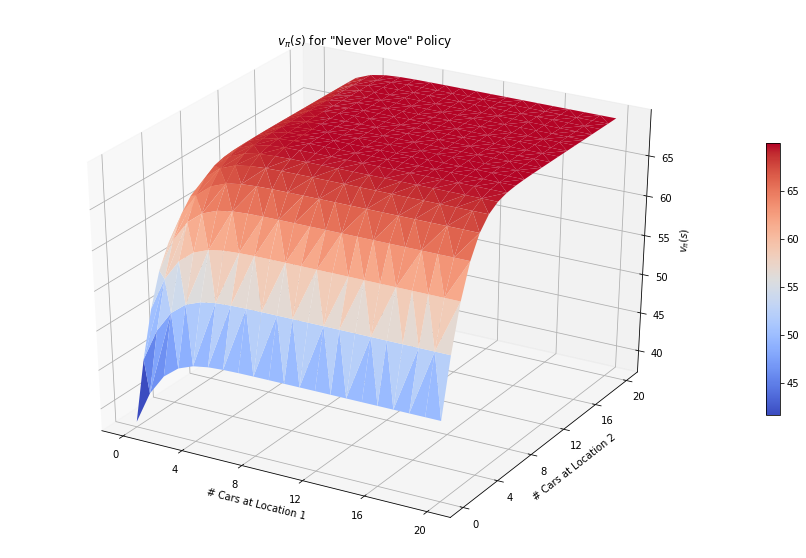

In [120]:
plot_policy(recon_vals, max_cars)